In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

```sh
build/dpdkproj -l 0-15 -- -p 60:45:bd:d2:73:1c -r 15 -t 1 sendrecv -s ~/dpdk-dpdk.csv --src 10.0.0.5 --src-port-range 10000-30000 --dest 10.0.0.8:10000 --dest-mac 12:34:56:78:9a:bc --stats-evict-interval-secs 120 --stats-evict-threshold-secs 1 --stats-interval-ms 1
 --packet-size 16 -R 3500 --burst-size 32

build/dpdkproj -l 0-15 -- reflect -p 60:45:bd:f2:0b:e8 -r 16 -t 16 -s /dev/stdout --stats-evict-interval-secs 5 --stats-evict-threshold-secs 1 --stats-interval-ms 1000 --burst-size 128
 ```

In [2]:
plt.xkcd(scale=0.35)

In [3]:
data = pd.read_csv("dpdk-dpdk-3500-3-hour.csv")[:-1000]

def transform(df):
  df["time"] /= 1000
  time_step = df["time"][1] - df["time"][0]
  df["time"] = pd.to_timedelta(df["time"], unit="s")
  df.set_index("time", inplace=True)
  df["tx_packets"] /= time_step
  df["rx_packets"] /= time_step
  df = df.resample("1S", origin="start").mean()
  return df

data = transform(data)
data.head()

,tx_packets,rx_packets,drop_rate,avg_latency
time,,,,
0 days 00:00:00,951540.0,948020.0,0.001097,0.000957
0 days 00:00:01,3500000.0,3495936.0,0.001161,0.000039
0 days 00:00:02,3500000.0,3493835.0,0.001761,0.000000
0 days 00:00:03,3500000.0,3495463.0,0.001296,0.000026
0 days 00:00:04,3500000.0,3494004.0,0.001713,0.000000


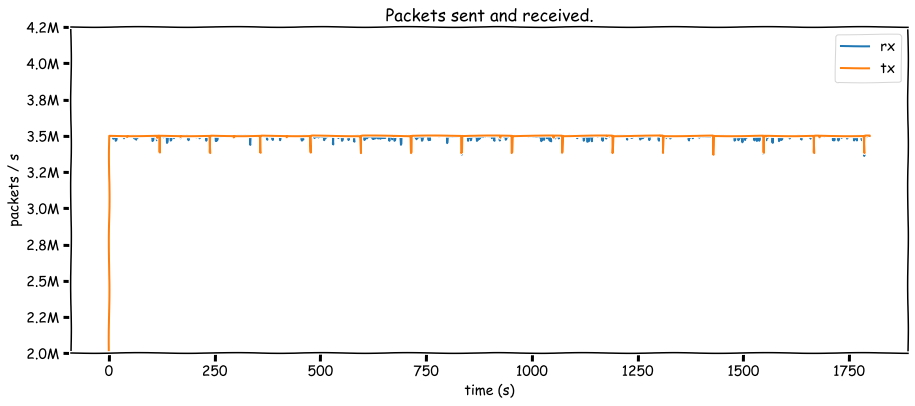

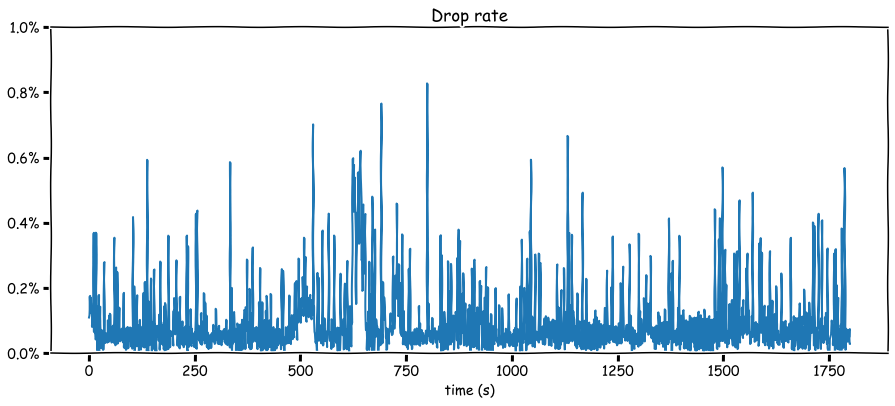

In [4]:
# plot packet stats
lims = (2e6, 4.25e6)

graph_data = data[:1800]

fig = plt.figure(figsize=(15, 6))
plt.plot(graph_data.index.seconds, graph_data["rx_packets"], label="rx")
plt.plot(graph_data.index.seconds, graph_data["tx_packets"], label="tx")
plt.ylabel("packets / s")
plt.xlabel("time (s)")
plt.ylim(lims)
plt.title("Packets sent and received.")
plt.legend()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
plt.savefig("packets.svg")

fig = plt.figure(figsize=(15, 6))
plt.plot(graph_data.index.seconds, graph_data["drop_rate"])
plt.xlabel("time (s)")
plt.ylim(0, 0.01)
plt.title("Drop rate")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x*100:.1f}%"))
plt.savefig("drops.svg")

## Note on latency

The latency measurement is likely to be completely inaccurrate when it gets smaller than 1ms due to the unit of time being milliseconds, and values recorded as integer.

Text(0.5, 1.0, 'Average latency')

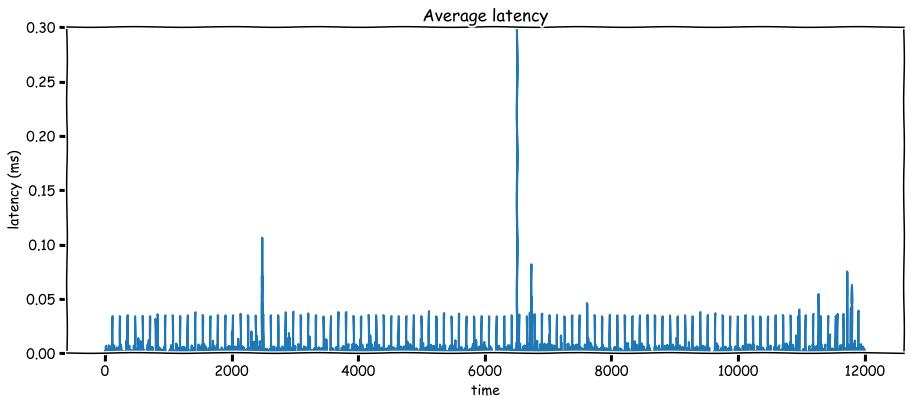

In [5]:
# Plot latency
lims = (0, 0.3)

fig = plt.figure(figsize=(15, 6))
plt.plot(data.index.seconds, data["avg_latency"])
plt.ylabel("latency (ms)")
plt.ylim(lims)
plt.xlabel("time")
plt.title("Average latency")

## Average drop rate and latency

In [6]:
str(np.mean(data["drop_rate"]) * 100) + "%"

'0.11254540697273065%'

In [7]:
str(np.mean(data["avg_latency"])) + "ms"

'0.001036256883277428ms'